In [191]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u

import sys
sys.path.insert(0, '../')

In [2]:
from astropy.io import fits

f = fits.getdata('../libra/data/trappist_everest_luger.fits')

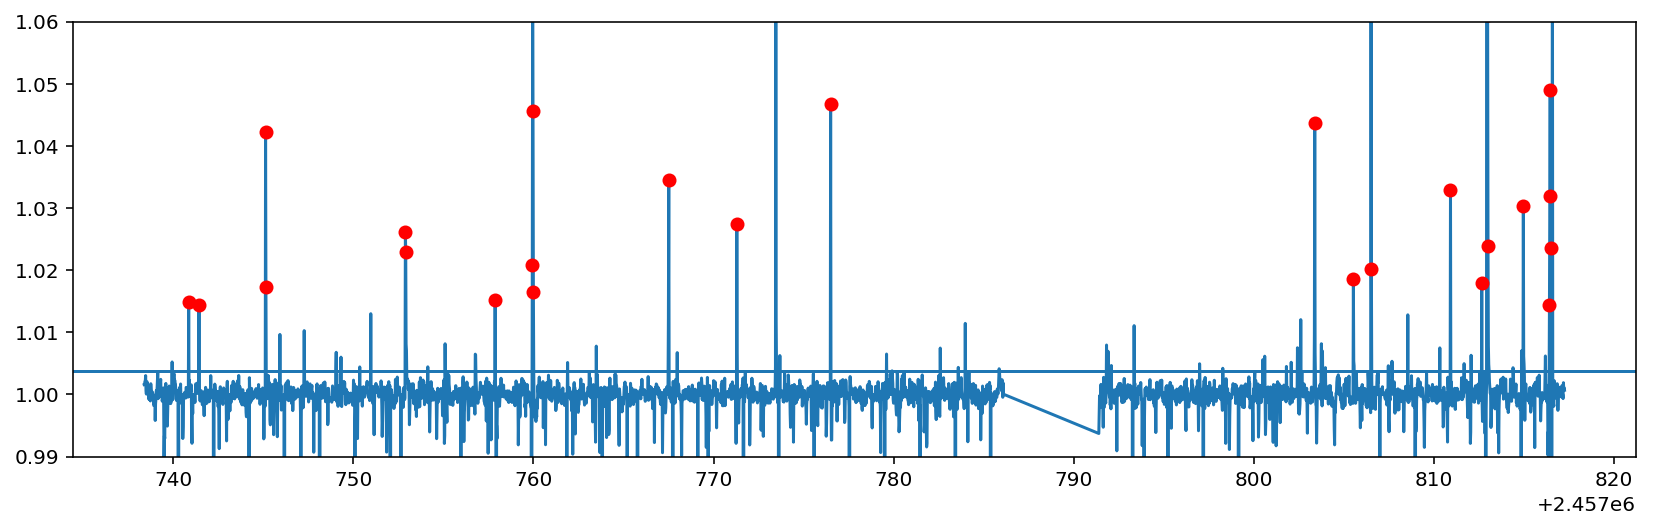

In [116]:
%matplotlib inline
k2_time, k2_flux = f['TIME'] + 2454833, f['FLUX']

mask = (k2_flux > 0)

k2_flux /= np.median(k2_flux[mask])

from scipy.signal import medfilt

# p = np.polyfit(k2_time[mask], medfilt(k2_flux[mask], (31,)), 4)

med_filt = medfilt(k2_flux[mask], (31,))
filtered_fluxes = k2_flux[mask]/med_filt

from astropy.stats import mad_std
threshold = mad_std(filtered_fluxes)

candidate_flares = filtered_fluxes > 1.01 + std

#k2_flux += 1 - np.polyval(p, k2_time)
plt.figure(figsize=(14, 4))
plt.plot(k2_time[mask], filtered_fluxes)

plt.plot(k2_time[mask][candidate_flares], filtered_fluxes[candidate_flares], 'ro')

plt.ylim([0.99, 1.06])
plt.axhline(1+std)
# plt.xlim([2457740, 2457742])

In [121]:
k2_time[mask][candidate_flares]

array([ 2457740.8491317 ,  2457741.42123857,  2457745.11949007,
        2457745.13992235,  2457752.88371535,  2457752.90414742,
        2457757.86911462,  2457759.93273949,  2457759.9531715 ,
        2457759.9736034 ,  2457759.99403521,  2457767.51294912,
        2457771.29281912,  2457773.45857741,  2457776.50289287,
        2457803.39079186,  2457805.53610374,  2457806.5168182 ,
        2457806.53724975,  2457810.9300382 ,  2457812.66672449,
        2457812.95276713,  2457812.97319864,  2457812.99363035,
        2457813.01406197,  2457814.97549825,  2457816.42614548,
        2457816.44657713,  2457816.46700869,  2457816.48744044,
        2457816.58959873])

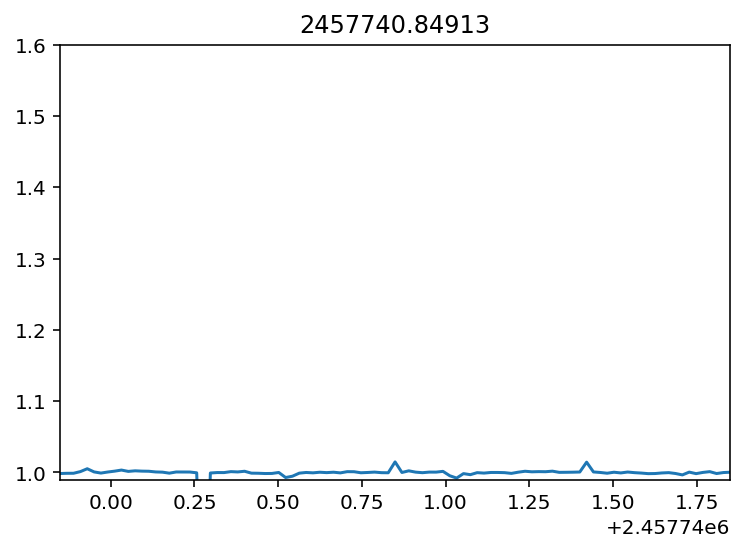

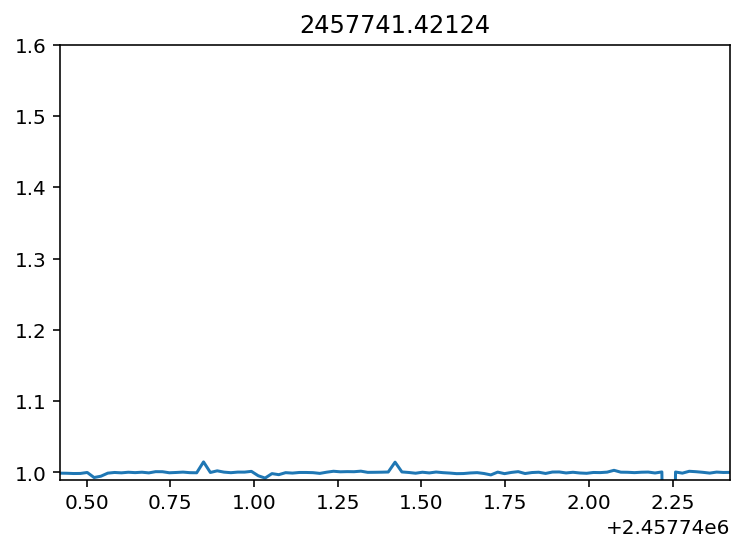

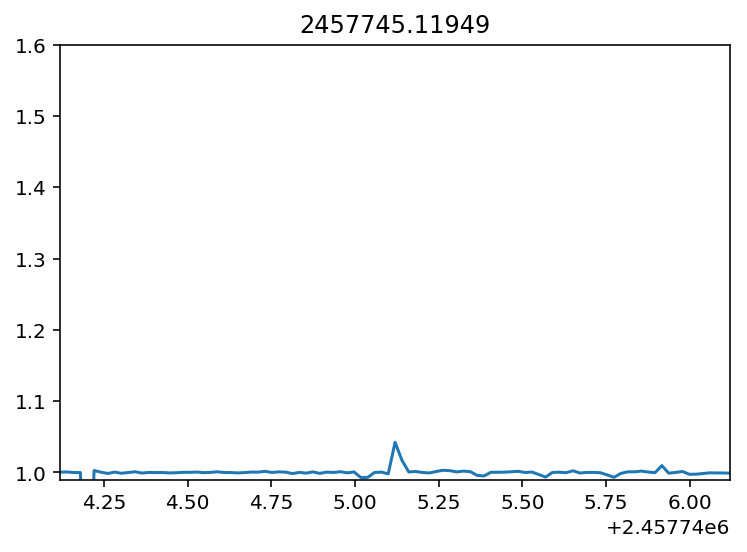

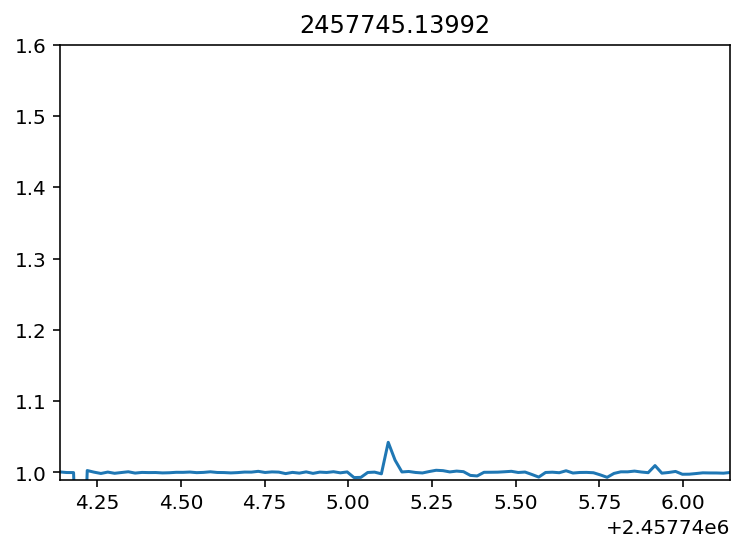

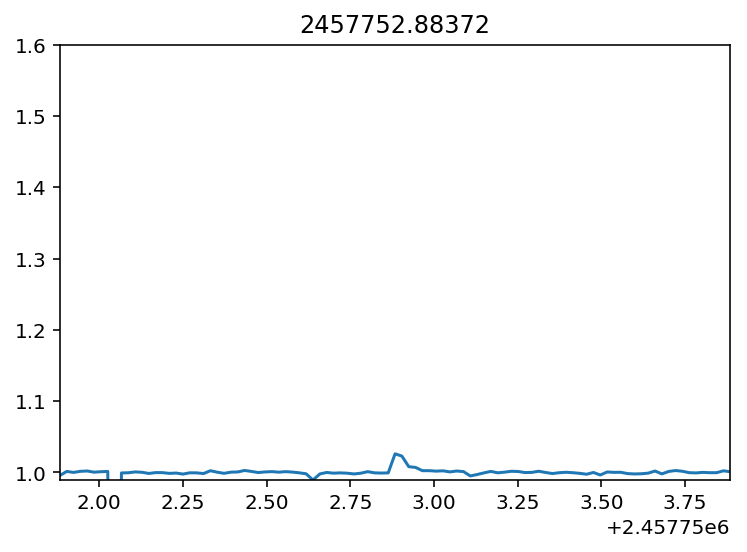

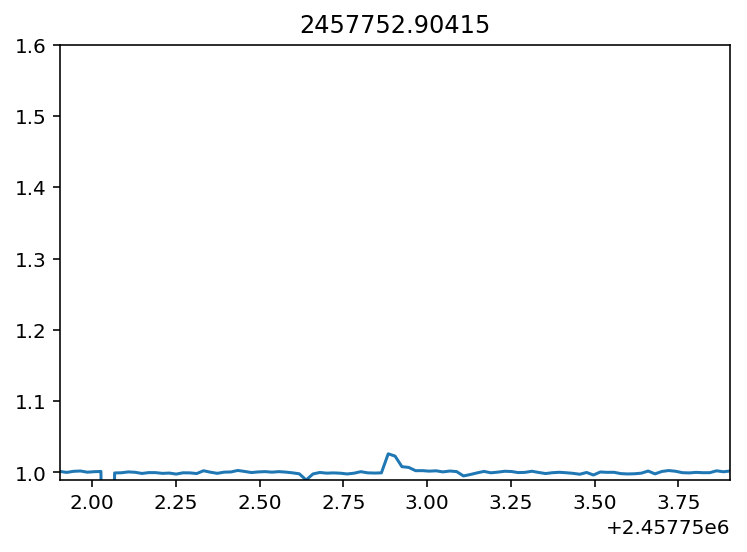

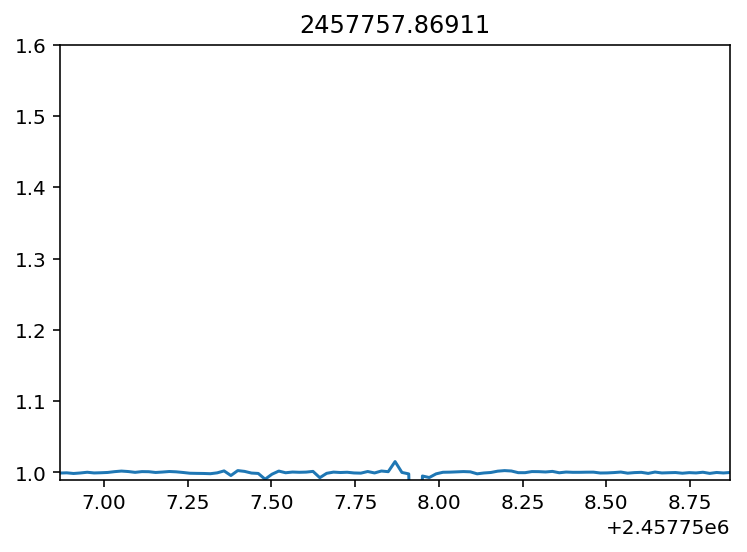

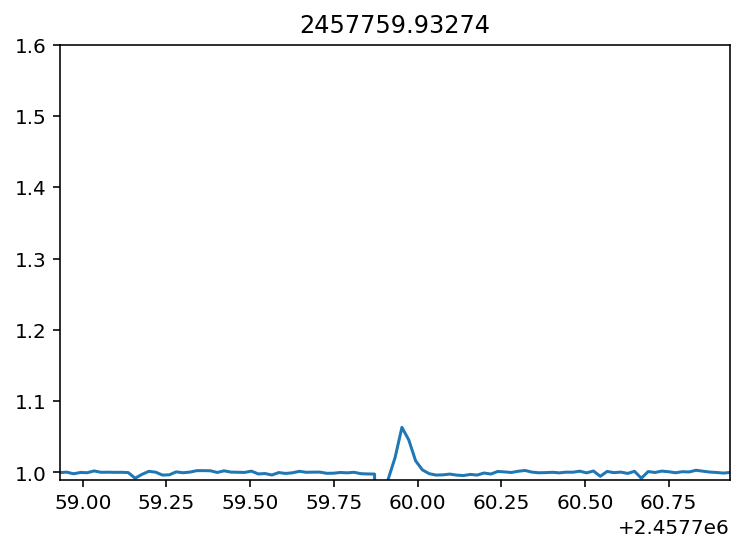

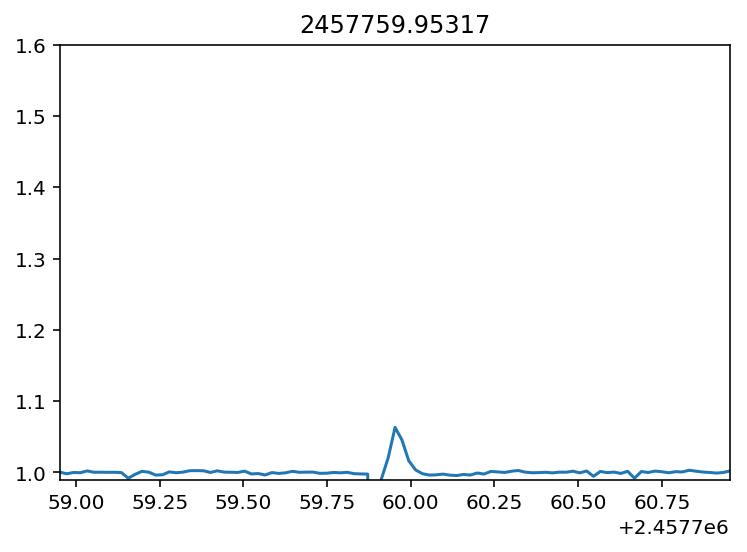

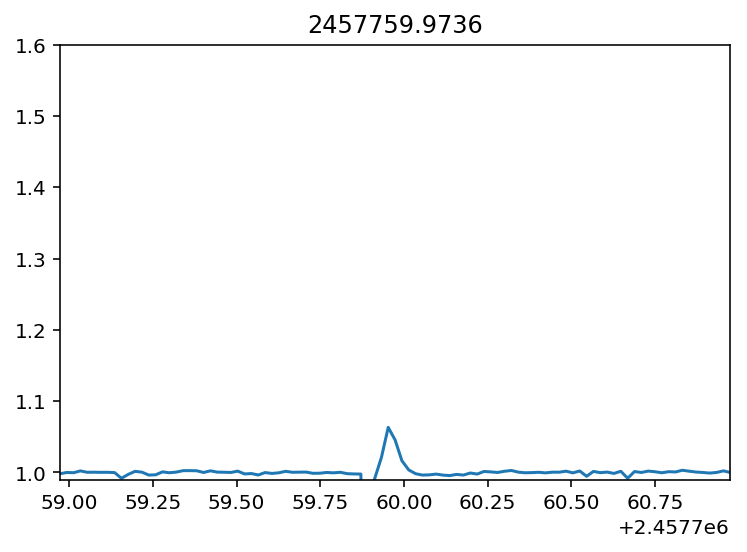

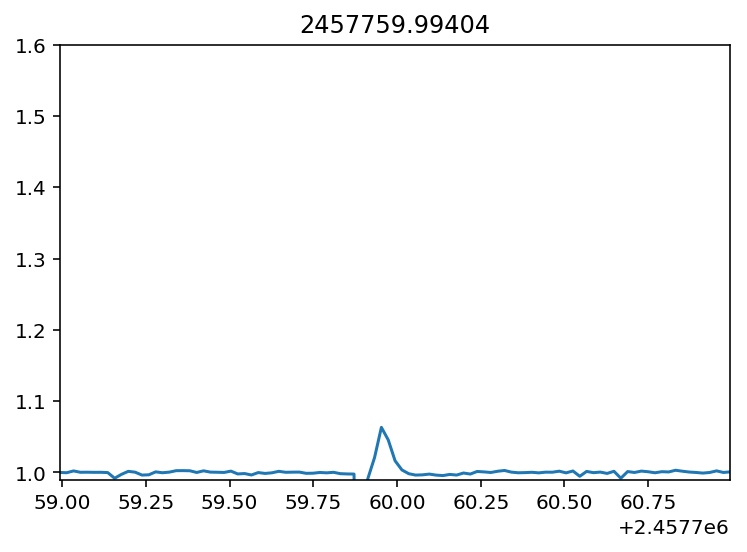

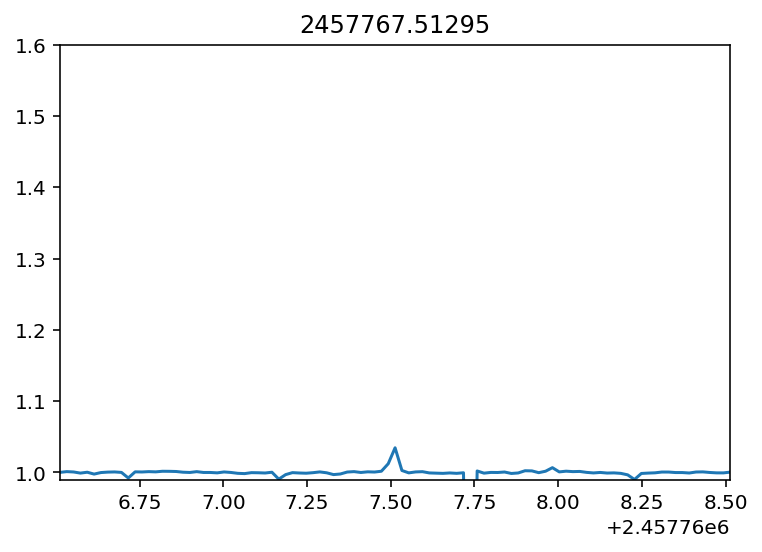

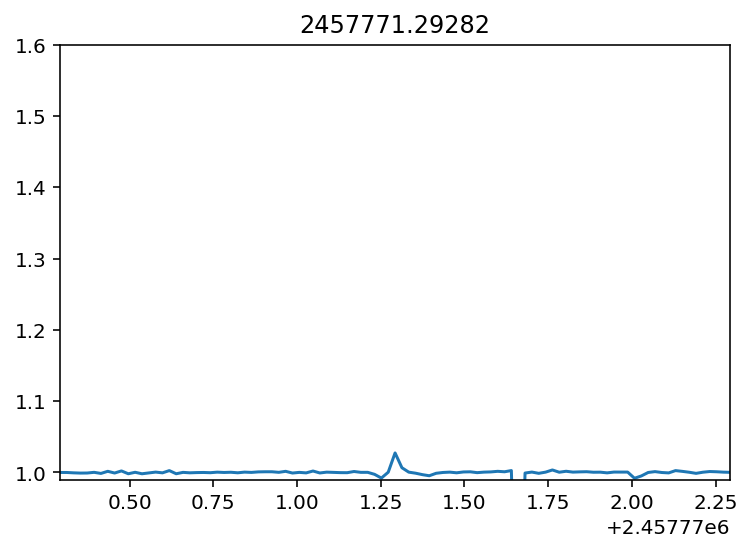

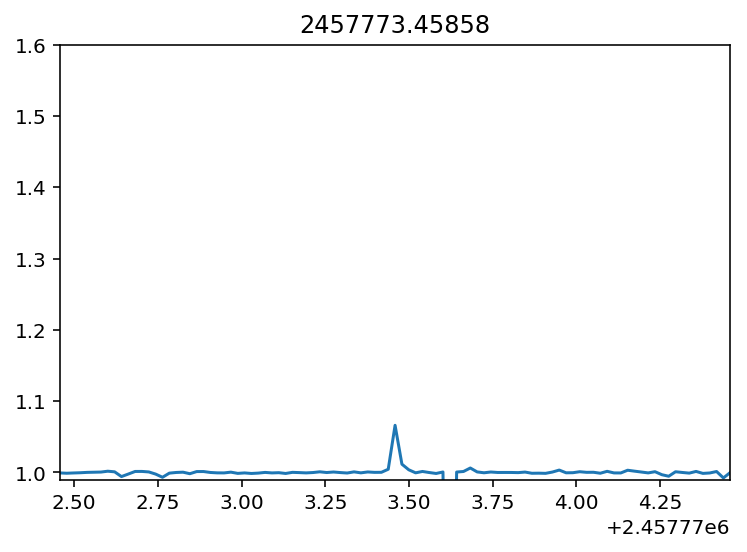

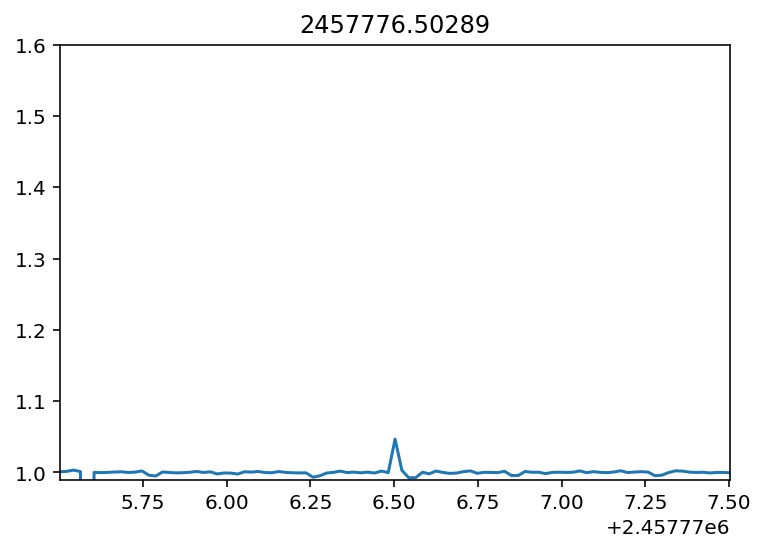

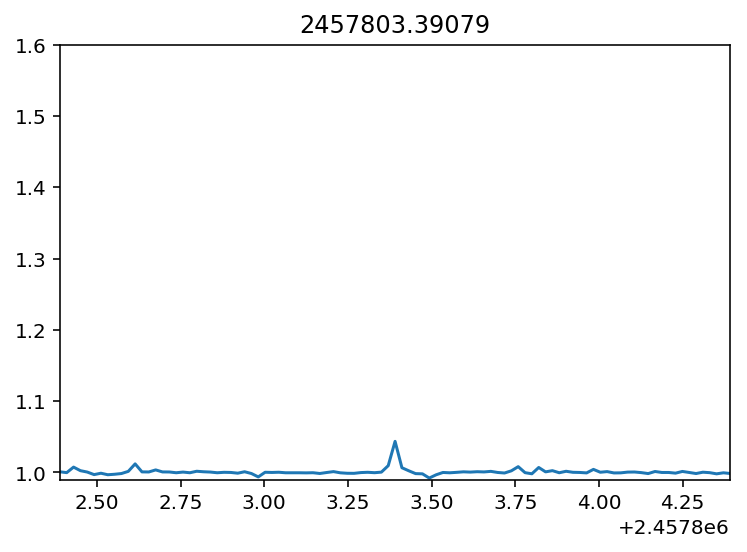

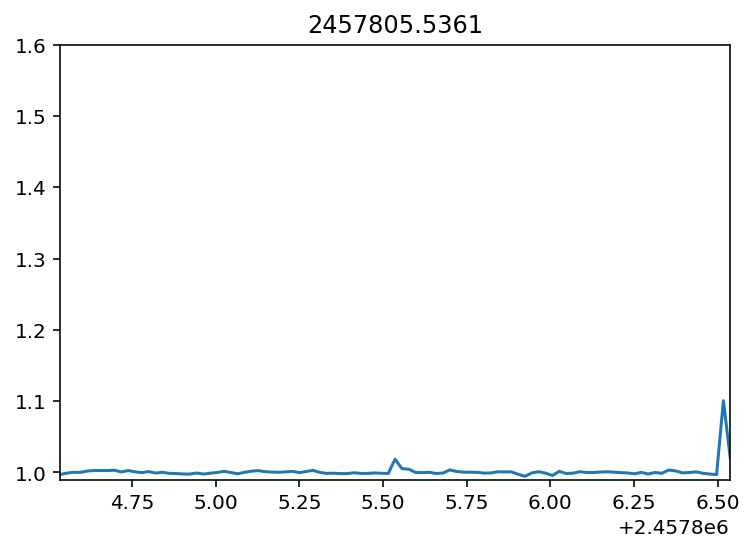

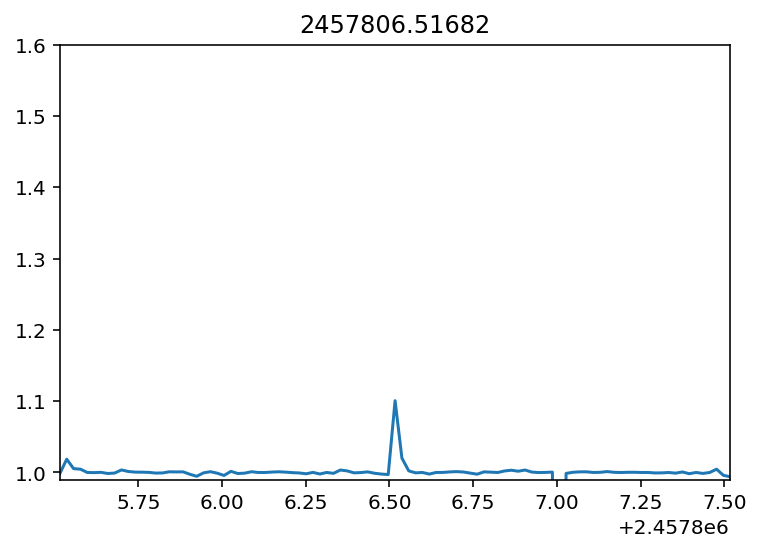

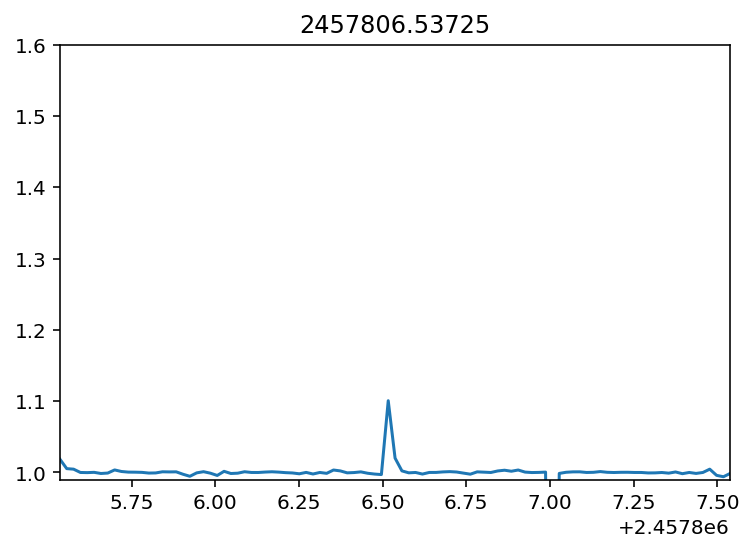

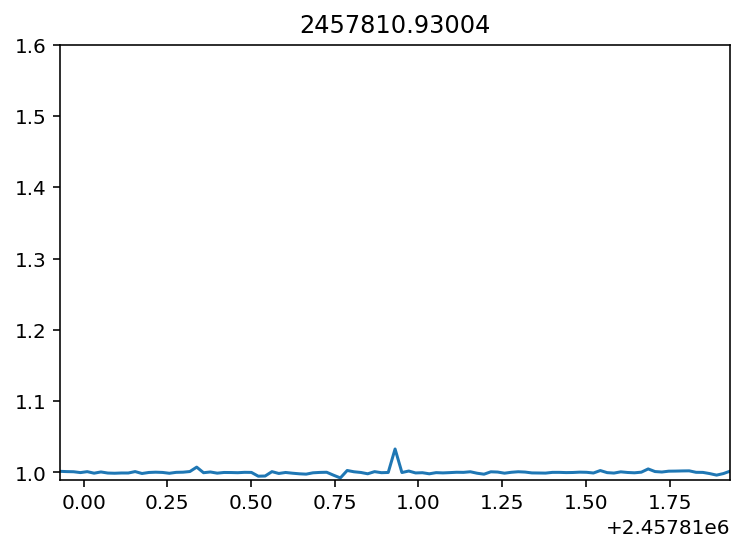

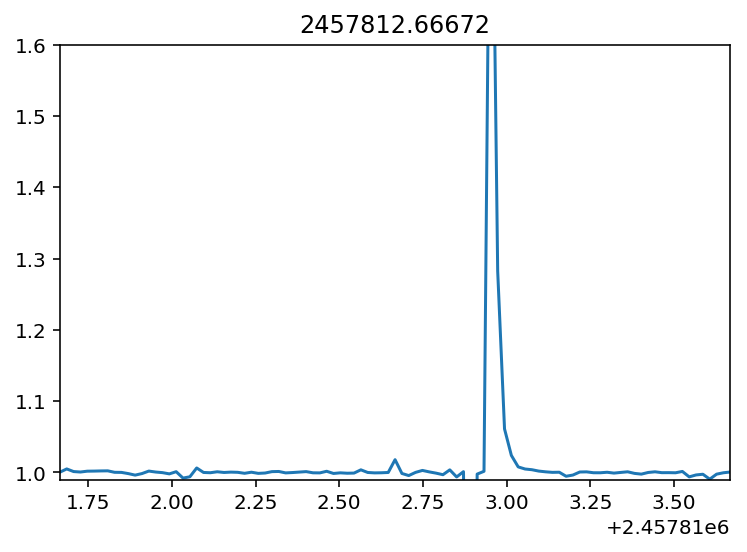

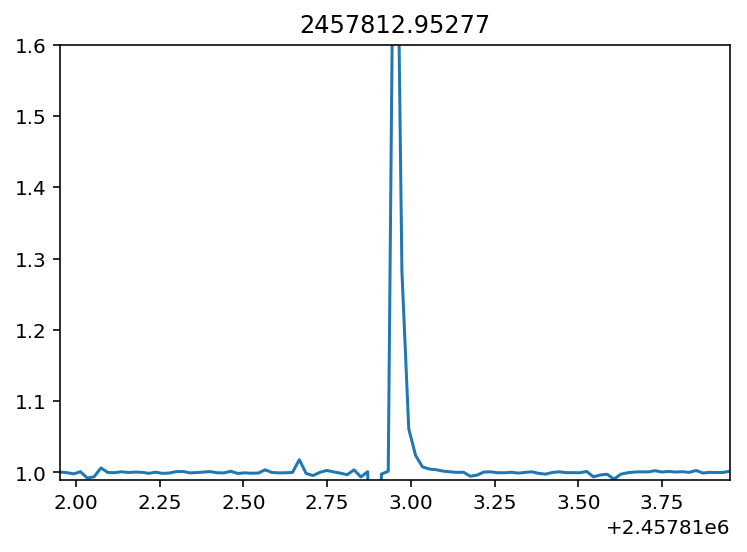

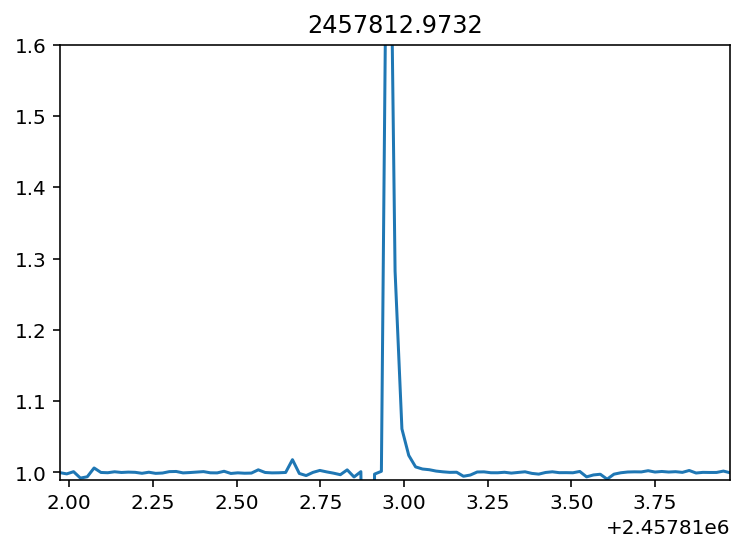

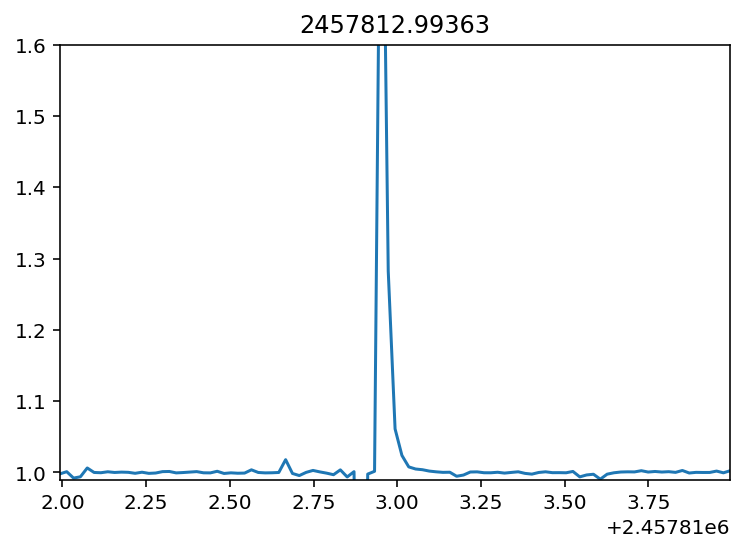

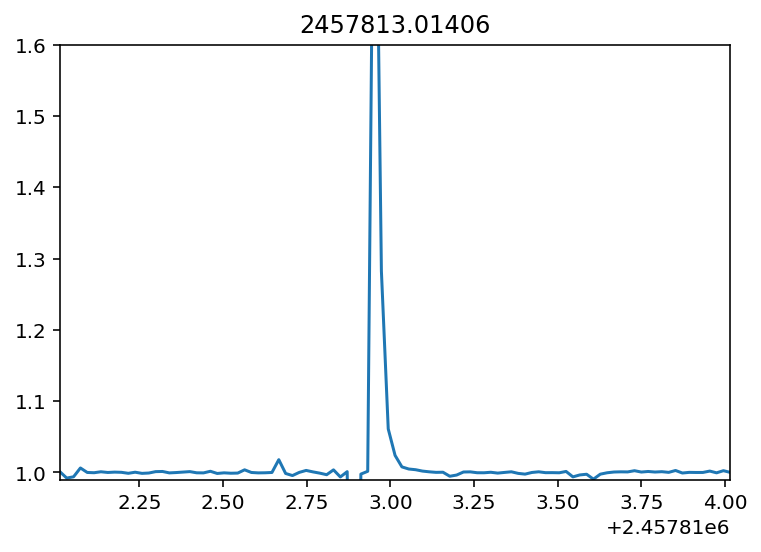

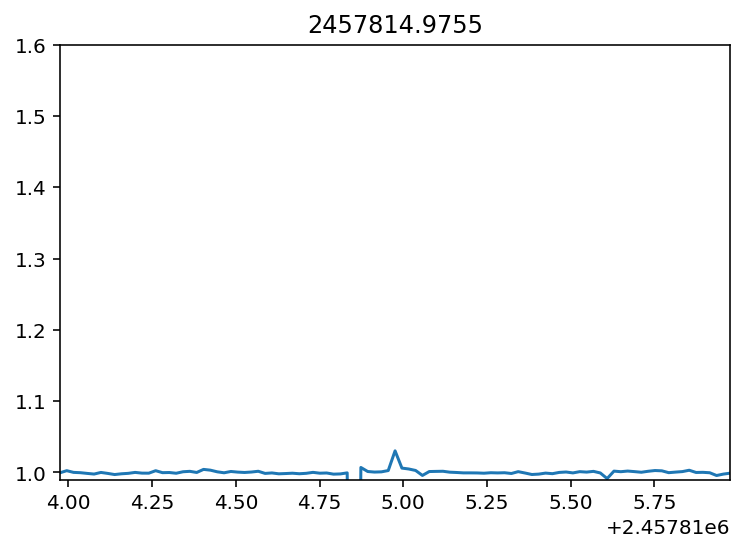

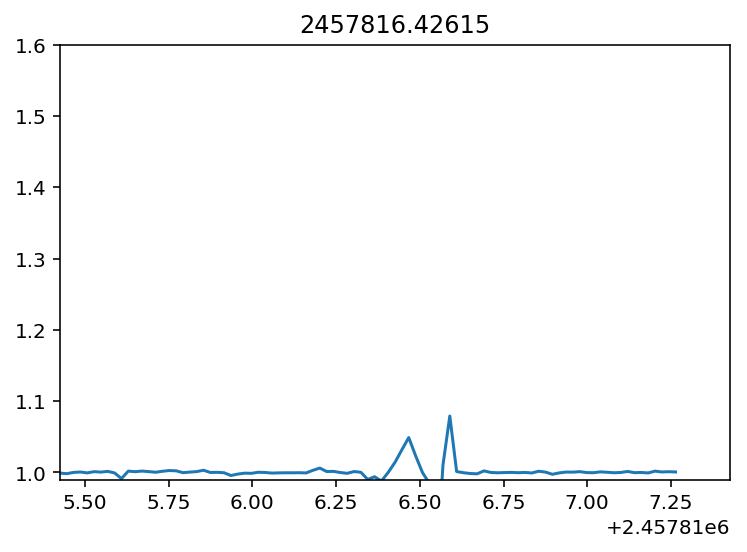

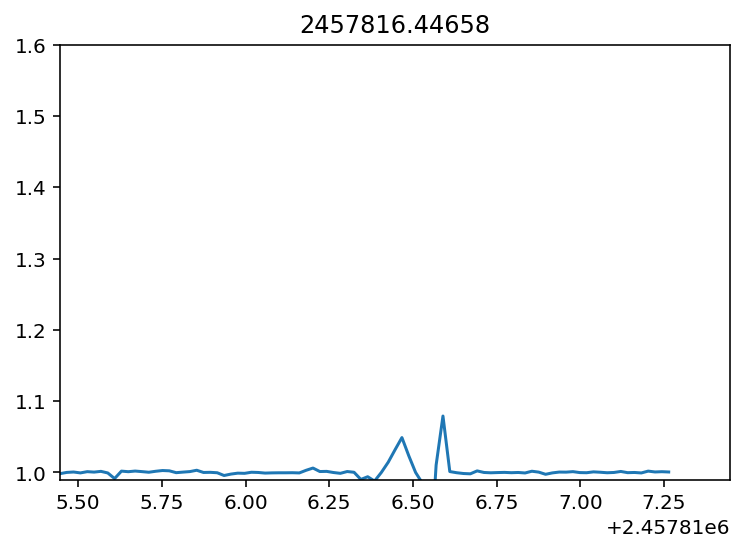

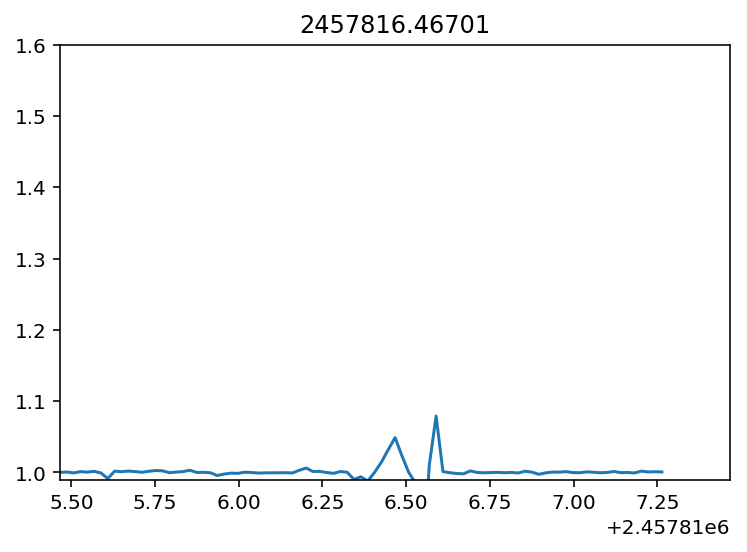

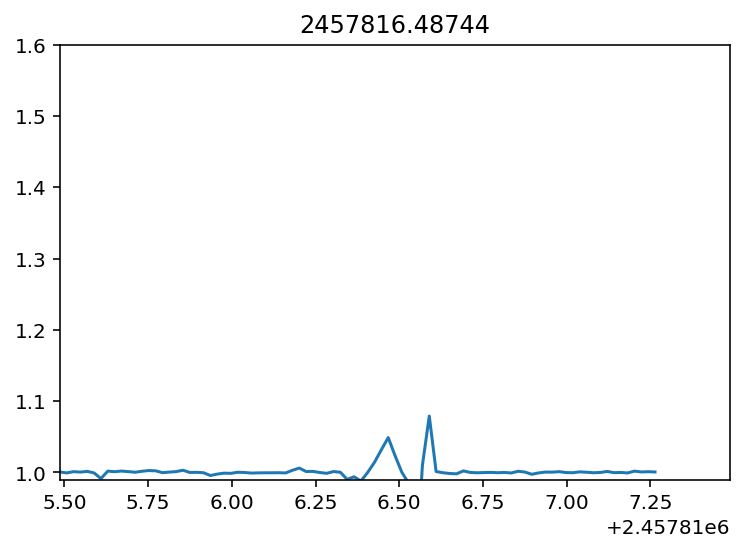

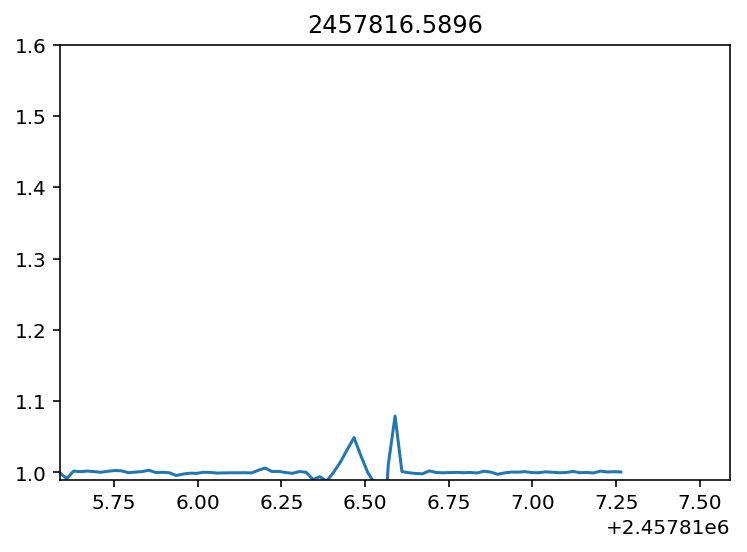

In [155]:
for t in k2_time[mask][candidate_flares]:
    plt.figure()
    plt.plot(k2_time[mask], filtered_fluxes)


    plt.xlim([t-1, t+1])
    plt.ylim([0.99, 1.6])
    plt.title(t)
    plt.show()

In [184]:
flares = np.array([2457745.11, 2457745.11949007, 2457752.88371535, 
                   2457759.93273949, 2457759.9736034, 2457771.29281912,  
                   2457773.45857741, 2457776.50289287,
                   2457803.39079186,  2457806.5168182 , 
                   2457813.01406197])

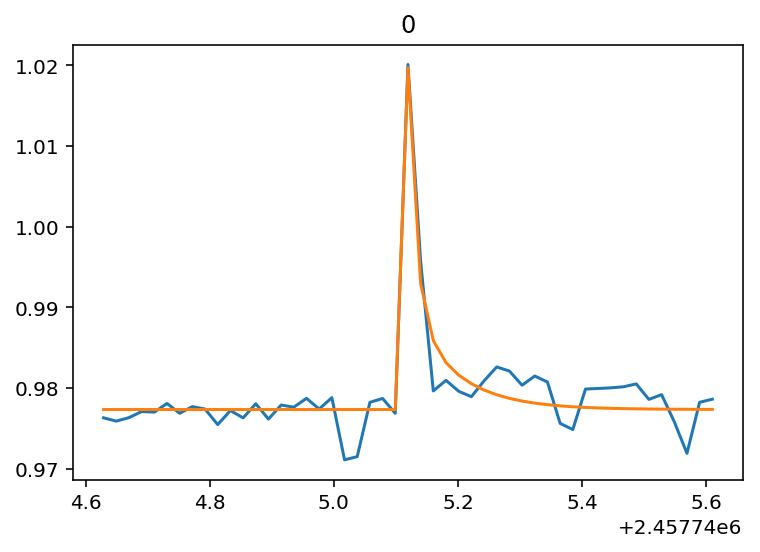

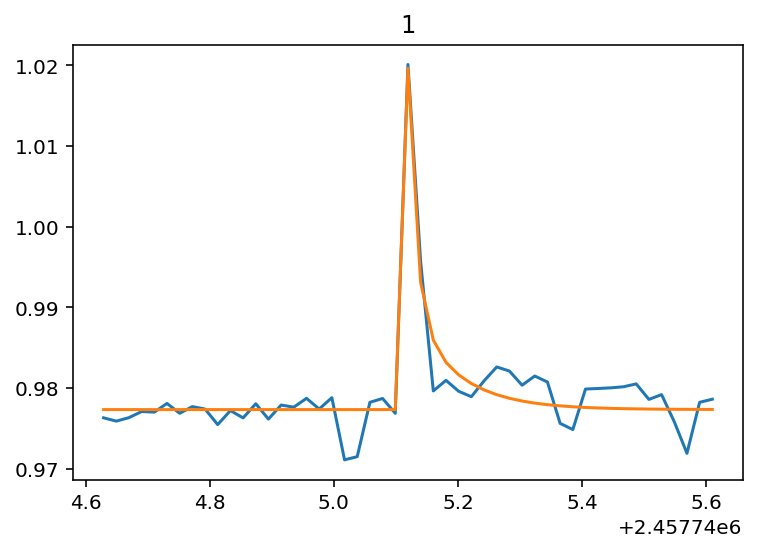

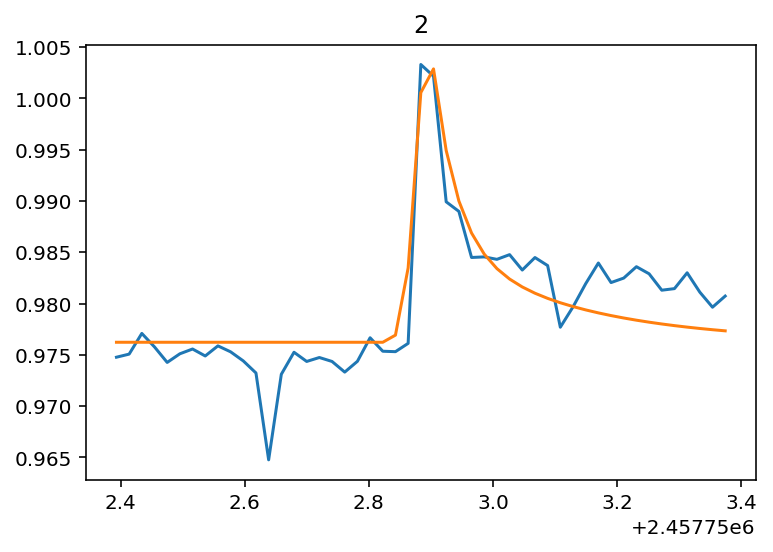

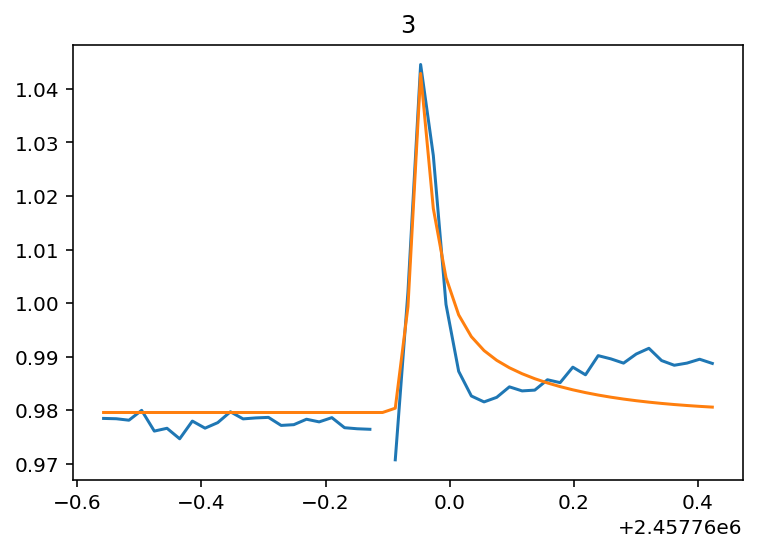

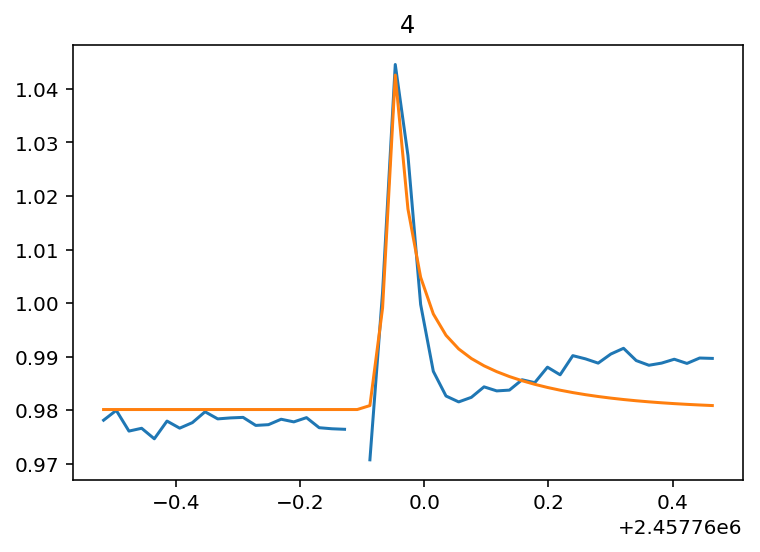

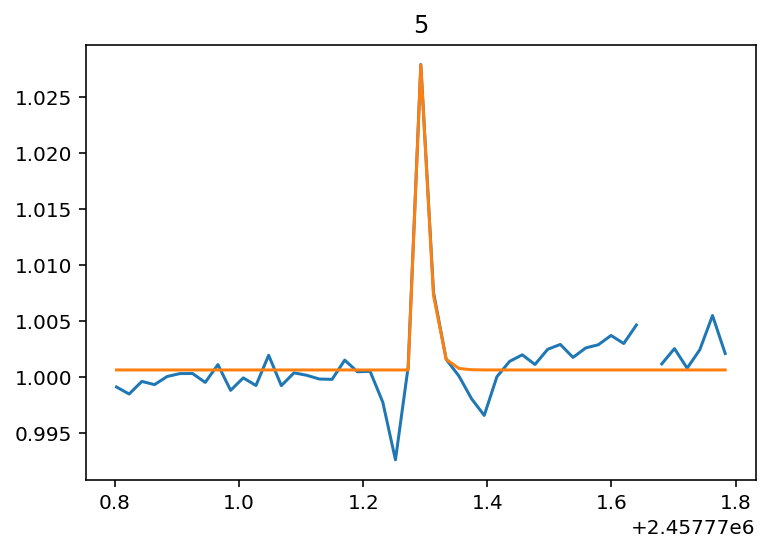

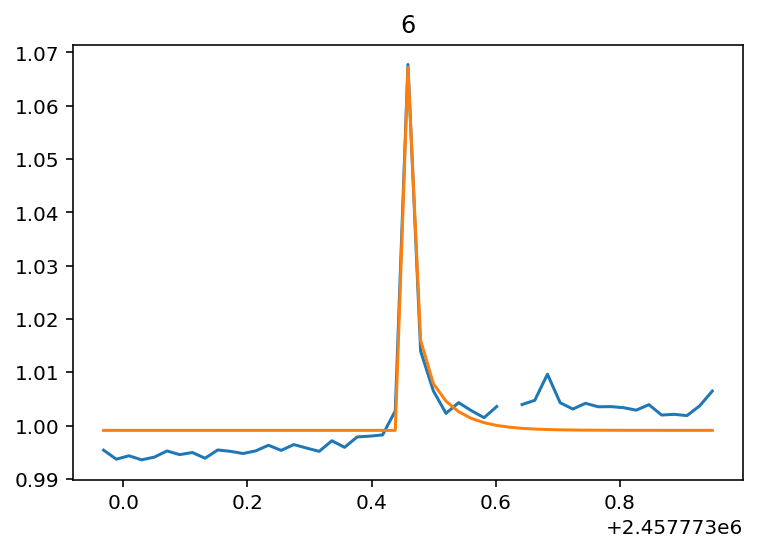

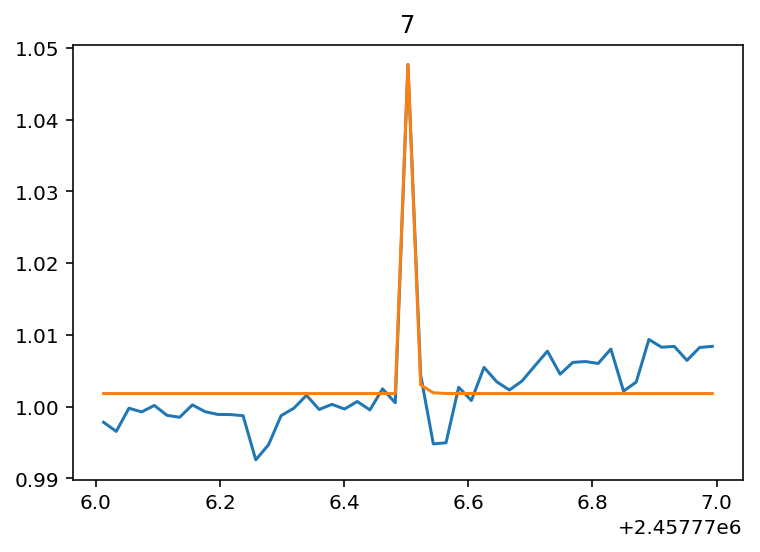

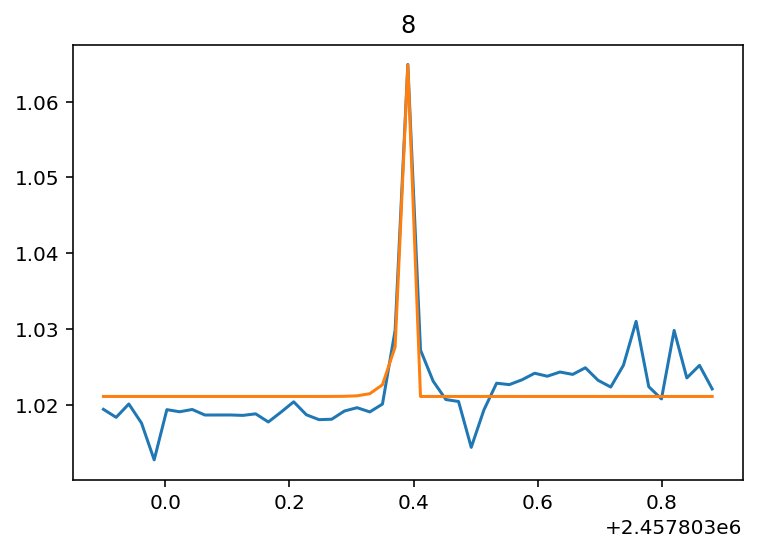

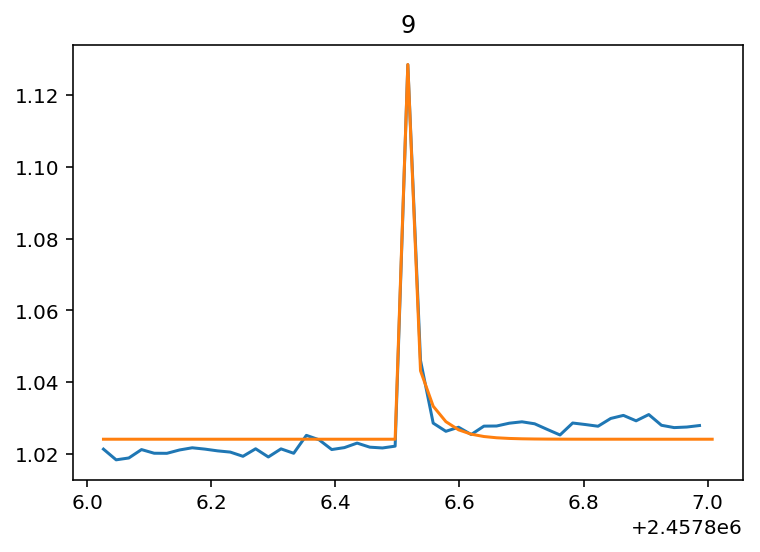

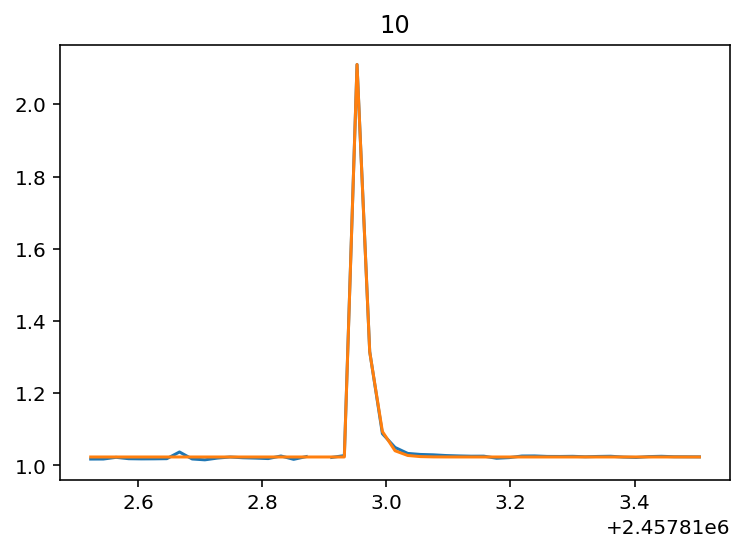

In [185]:
from libra.flares import flare_flux

#flare_times = [2457773.47900917, 2457752.88371535, 2457812.97319864]

def model(p, times):
    peak_flux, t0, halfdur, offset = p
    return offset + flare_flux(times, t0, peak_flux, halfdur)

def chi2(p, times, fluxes):
    return np.nansum((model(p, times) - fluxes)**2)

from scipy.optimize import fmin_powell

fit_results = []

for i, t0 in enumerate(flares):
    plt.figure()
    chunk = np.abs(k2_time[mask] - t0) < 0.5
    chunk_time = k2_time[mask][chunk]
    chunk_flux = k2_flux[mask][chunk]
    
    bounds = [[0.0, 3], [t0 - 0.1, t0 + 0.1], 
              [0, 0.5], [0.9, 1.1]]
    
    chunk_flux[chunk_flux < 0.9] = np.nan
    initp = [np.nanmax(chunk_flux) - 1, t0, 0.01, 1]
    result = fmin_powell(chi2, initp, args=(chunk_time, chunk_flux), disp=0)

    plt.plot(chunk_time, chunk_flux)
    plt.plot(chunk_time, model(result, chunk_time))
    plt.title(i)
    
    fit_results.append(result)
fit_results = np.array(fit_results)

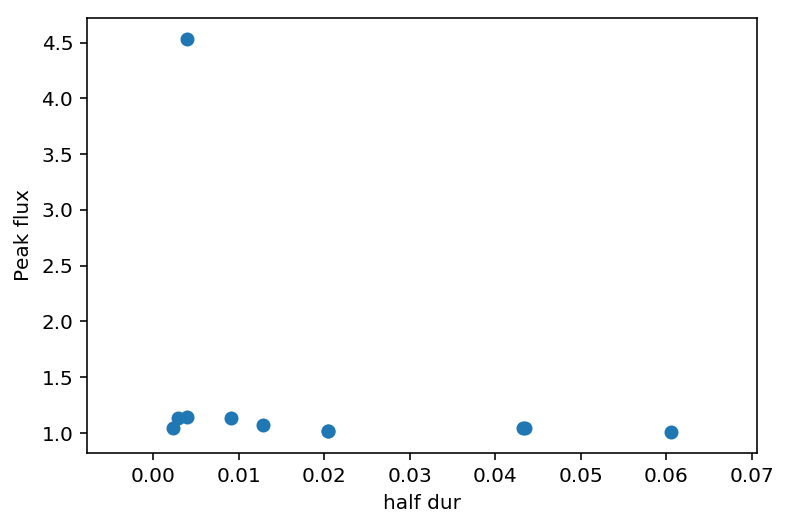

In [187]:
plt.scatter(abs(fit_results[:, 2]), (fit_results[:, 0] + fit_results[:, 3]))
plt.ylabel('Peak flux')
plt.xlabel('half dur')

np.savetxt("../libra/data/flares/trappist1_morris.txt", 
           np.vstack([abs(fit_results[:, 2]), 
                      (fit_results[:, 0] + fit_results[:, 3])]).T)